<a href="https://colab.research.google.com/github/tseesurenb/Cred/blob/master/UCF_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Merged data size: 100836 Movie data size: 9742 Rating data size: 100836
number of agg_rating 9719
The average movie rating for user1 is  4.39


,movie,movie_score,predicted_rating
60,"Shawshank Redemption, The (1994)",0.264472,4.657329
0,2001: A Space Odyssey (1968),0.213674,4.606531
33,"Godfather, The (1972)",0.210781,4.603638
34,"Godfather: Part II, The (1974)",0.206426,4.599283
26,Eternal Sunshine of the Spotless Mind (2004),0.201136,4.593993
48,"Lord of the Rings: The Return of the King, The...",0.184004,4.576861
13,Blade Runner (1982),0.181134,4.573991
40,Inception (2010),0.176176,4.569033
22,"Departed, The (2006)",0.164265,4.557122
4,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0.150960,4.543817


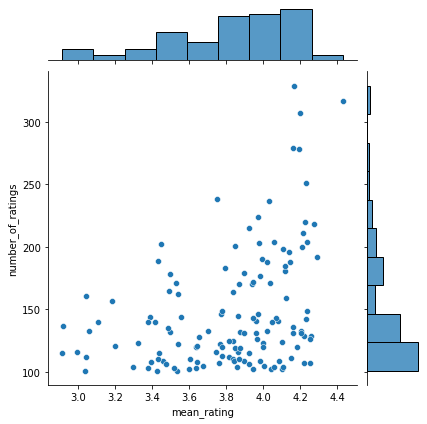

In [2]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change directory
#import os
#os.chdir("drive/My Drive/contents/recommendation_system")

# Print out the current directory
# !pwd

# Read in data
ratings=pd.read_csv('ml-latest-small/ratings.csv')

# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

#print('# of potential all rating', ratings['movieId'].nunique()*ratings['userId'].nunique())
# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

# Read in data
movies = pd.read_csv('ml-latest-small/movies.csv')

# Merge ratings and movies datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')
print('Merged data size:', df.shape[0],'Movie data size:', movies.shape[0], 'Rating data size:', ratings.shape[0])

# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count')).reset_index()
print('number of agg_rating', agg_ratings.shape[0])

# Keep the movies with over 100ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]

# Check popular movies
#agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

# Visualization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')

# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')

# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')

# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()

# User similarity matrix using cosine similarity
#user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))

# Pick a user ID
picked_userid = 1

# Remove picked user ID from the candidate list
user_similarity.drop(index = picked_userid, inplace=True)

# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid] > user_similarity_threshold][picked_userid]

# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')

# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')

# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns, axis=1, inplace = True, errors ='ignore')

# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns = ['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user
print(f'The average movie rating for user{picked_userid} is {avg_rating: .2f}')

# Calculate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)